In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ADOP dataset Classification

"The APOD dataset is the dataset of "Astronomy Picture of the Day" which is a collection of images provided by NASA. The dataset includes images from different categories of astronomy such as planets, galaxies, nebulae, etc. I am using VGG16 to classify images either real or fake for this a super effective technique is to use Transfer Learning where I am using pre-trained model of VGG16. The benefits of using pre-trained model is:

**1:**Reduced Training Time: The VGG16 model has already been trained on a large dataset, such as ImageNet. By using a pre-trained model, you can avoid the need to train a model from scratch on the APOD dataset. This can save a lot of time and computational resources.

**2:**Better Performance: The VGG16 model has already been trained to recognize a wide variety of objects, which means it has already learned features that are useful for image classification tasks. These features can be used as a starting point to train a new model on the APOD dataset, which can lead to better performance than training a model from scratch.

**3:**Handling Small Dataset: The APOD dataset may not be as large as other datasets such as ImageNet, by using transfer learning with a pre-trained model, you can utilize the knowledge of the model learned from the large dataset, this can help improve the performance of the model on the smaller APOD dataset.

**4:**Fine-tuning: With transfer learning, you can fine-tune the pre-trained model on your dataset. This means that you can train the model on your dataset while keeping the pre-trained weights fixed, and only update the last few layers, this can help to learn features that are specific to the dataset you're working with, and improve the performance of the model."

In [ ]:
# Import modules
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras.applications import VGG16
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import glob


In [ ]:
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


It creates two instances of the ImageDataGenerator class from the keras.preprocessing.These instances are used to preprocess the images in the training and validation datasets.

The validation_datagen instance is used to preprocess the validation dataset. It is initialized with the rescale parameter set to 1/255. 
The train_datagen instance is used to preprocess the training dataset.It also includes several additional data augmentation techniques :
**rotation_range** - randomly rotate the image by an angle within the given range
**width_shift_range** and h**eight_shift_range** - randomly shift the image horizontally and vertically
**shear_range** - apply random shearing transformation
**zoom_range** - randomly zoom in and out of the image

These data augmentation techniques are used to artificially increase the size of the training dataset by applying various transformations to the images. This can help to improve the model's ability to generalize to new data by exposing it to more varied examples during training.

In [ ]:
validation_datagen=ImageDataGenerator(rescale=1/225)
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2)

In [ ]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/APOD_dataset/APOD_Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory('/content/drive/MyDrive/APOD_dataset/APOD_Valid',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 7000 images belonging to 2 classes.
Found 2183 images belonging to 2 classes.


# Training Model (used VGG16 model)

The first line of the code initializes the VGG16 model with the following parameters:

**weights**:Means the model will be initialized with the pre-trained weights that have been trained on the ImageNet dataset.
**include_top:** whether or not to include the fully connected layers that were used for the ImageNet classification task. In this case, it is set to False, which means the fully connected layers will not be included.
**input_shape:** the shape of the input images. In this case, it is set to (224, 224, 3)

Then the model is modified by adding a new fully connected layer with 2 output units (for real and fake) . The GlobalAveragePooling2D() layer is used to reduce the dimensions of the output from the VGG16 model, and the Dense(2, activation='softmax') layer is added as the output layer. This new output layer will be responsible for classifying the images as real or fake. Finally, the full model is created by instantiating a new Model object and specifying the input 

In [ ]:
# initialize the VGG16 model
model = VGG16(weights='imagenet',include_top=False, input_shape=(224, 224, 3))
#Add a GlobalAveragePooling2D layer to the base model
x = model.output
x = GlobalAveragePooling2D()(x)
# add a new fully connected layer with 2 output units (for real and fake)
predictions = Dense(2, activation='softmax')(x)
# create the full model
model = Model(inputs=model.input, outputs=predictions)

In [ ]:
#Print the Summary Of model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Compile the final Model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
#Finally Fine Tune the Pre-Trained Model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.n // 32,
    epochs=30,
    validation_data=validation_set,
    validation_steps=validation_set.n // 32
    )

Epoch 1/30
218/218 [==============================] - 131s 601ms/step - loss: 0.3951 - accuracy: 0.8189 - val_loss: 0.4716 - val_accuracy: 0.7647
Epoch 2/30
218/218 [==============================] - 132s 604ms/step - loss: 0.3719 - accuracy: 0.8342 - val_loss: 0.4462 - val_accuracy: 0.8061
Epoch 3/30
218/218 [==============================] - 133s 610ms/step - loss: 0.3682 - accuracy: 0.8330 - val_loss: 0.4486 - val_accuracy: 0.7964
Epoch 4/30
218/218 [==============================] - 134s 616ms/step - loss: 0.3563 - accuracy: 0.8430 - val_loss: 0.5519 - val_accuracy: 0.7858
Epoch 5/30
218/218 [==============================] - 134s 614ms/step - loss: 0.3429 - accuracy: 0.8463 - val_loss: 0.5201 - val_accuracy: 0.8047
Epoch 6/30
218/218 [==============================] - 135s 617ms/step - loss: 0.3386 - accuracy: 0.8513 - val_loss: 0.4455 - val_accuracy: 0.8079
Epoch 7/30
218/218 [==============================] - 134s 614ms/step - loss: 0.3253 - accuracy: 0.8608 - val_loss: 0.3707 -

# Save the Model

In [ ]:
# save the model
model.save('/content/drive/MyDrive/APOD_trainnedset/APOD_dataset.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/APOD_trainnedset/APOD_dataset.h5)
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

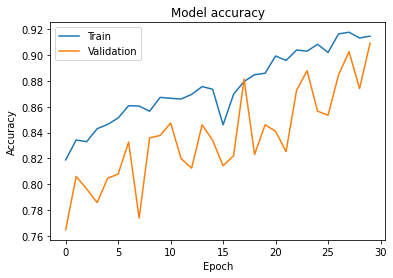

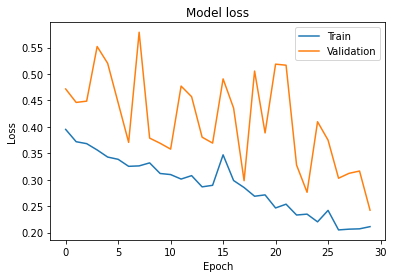

In [ ]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

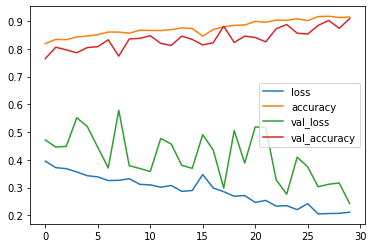

In [ ]:
#Visualise the Training, Validation Accuracy and Training, Validation Loss
import pandas as pdD

pd.DataFrame(
    history.history
).plot()

# Load Model

In [ ]:
model = load_model("/content/drive/MyDrive/APOD_trainnedset/APOD_dataset.h5")

In [ ]:
# Evaluate the model on the test dataset
val_loss, val_accuracy = model.evaluate(validation_set)
print("Test loss:", val_loss)
print("Test accuracy:", val_accuracy)

69/69 [==============================] - 12s 165ms/step - loss: 0.2430 - accuracy: 0.9084
Test loss: 0.24302515387535095
Test accuracy: 0.9083829522132874


In [ ]:
#Test the model predictions on test images
testing_data = glob.glob("/content/drive/MyDrive/APOD_dataset/mix_match/*")

In [ ]:
for im in testing_data:
  img = image.load_img(im, target_size=(224, 224))
  x = image.img_to_array(img)
  x /= 255
  x = np.expand_dims(x, axis=0)

  predictions = model.predict(x)
  predicted_class = np.argmax(predictions)
  
  if predicted_class == 1:
    print(f"{im} is REAL")
  if predicted_class == 0:
    print(f"{im} is FAKE")

1/1 [==============================] - 0s 19ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030301.jpg is REAL
1/1 [==============================] - 0s 15ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030222.jpg is REAL
1/1 [==============================] - 0s 15ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030219.jpg is REAL
1/1 [==============================] - 0s 16ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030221.jpg is FAKE
1/1 [==============================] - 0s 16ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030218.jpg is REAL
1/1 [==============================] - 0s 16ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030306.jpg is FAKE
1/1 [==============================] - 0s 15ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030217.jpg is REAL
1/1 [==============================] - 0s 17ms/step
/content/drive/MyDrive/APOD_dataset/mix_match/ap030220.jpg is REAL
1/1 [==============================] - 0s 17ms/s